# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import seaborn as sns


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames

df_calls = pd.read_csv('/datasets/megaline_calls.csv', sep = ',')
df_internet = pd.read_csv('/datasets/megaline_internet.csv', sep = ',')
df_messages = pd.read_csv('/datasets/megaline_messages.csv', sep = ',')
df_plans = pd.read_csv('/datasets/megaline_plans.csv', sep = ',')
df_users = pd.read_csv('/datasets/megaline_users.csv', sep = ',')
#print(df_plans)


## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
print(df_plans)


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Observando la tabla de las tarifas, se puede observar que el plan maneja los MB incluidos mensualmente y para mejor comprension tanto para clientes como para el analista, sería mejor convertir la columna a mb_per_month_included a gb_per_month_included y hacer la conversión de megabyte a gigabyte.

## Corregir datos

In [5]:
df_plans2 = df_plans.rename(columns = {'mb_per_month_included' : 'gb_per_month_included'}) # cambio de nombre de columnas 
df_plans2['gb_per_month_included'] = df_plans2['gb_per_month_included'] / 1024 # conversión de megabytes a gigabytes

col1 = df_plans2.pop('plan_name') #lineas para mover el nombre del plan como primera columna
df_plans2.insert(0,'plan_name', col1)
print(df_plans2)


  plan_name  messages_included  gb_per_month_included  minutes_included  \
0      surf                 50                   15.0               500   
1  ultimate               1000                   30.0              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


## Enriquecer los datos

In [6]:
df_plans2['gb_per_month_included'] = df_plans2['gb_per_month_included'].astype(int) #convertí los gb incluidos a números enteros
print(df_plans2)

  plan_name  messages_included  gb_per_month_included  minutes_included  \
0      surf                 50                     15               500   
1  ultimate               1000                     30              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios
print(df_users.head())


   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


La información del dataframe arroja que la columna donde está la fecha de registro no tiene el formato correcto, que es el de datetime. Por otra parte, también vemos la misma situación en la columna de churn_date.  A pesar de que hay muchos valores nulos, por el momento los dejaremos así ya que al inicio de las instrucciones nos comentan que valores ausentes significa que aún no cancelan su suscripción. Para la columna reg_date y churn_date, se tendría que confirgurar el tipo de dato a datetime.

### Corregir los datos

In [9]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%dT')# convierto a formato datetime
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%dT') # convierto a formato datetime
print(df_users.head(10))
df_users.info()

   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

    reg_date      plan churn_date  
0 2018-12-24  ultimate        NaT  
1 2018-08-13      surf        NaT  


### Enriquecer los datos

## Llamadas

In [10]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
# Imprime una muestra de datos para las llamadas
print(df_calls.head())


         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


La información de este dataframe arroja que no se encuentran datos ausentes. Sin embargo, de acuerdo a las normas de Megaline, si una llamada se excede tan siquiera un segundo de duración, se tomará en cuenta como si fuera un minuto más, por lo que se debe de redondear la columna de duración al siguiente entero y convertir el tipo de dato de la columna 'call_date' a un tipo datetime. 

### Corregir los datos

In [12]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%dT')# convierto a formato datetime
print(df_calls)

              id  user_id  call_date  duration
0        1000_93     1000 2018-12-27      8.52
1       1000_145     1000 2018-12-27     13.66
2       1000_247     1000 2018-12-27     14.48
3       1000_309     1000 2018-12-28      5.76
4       1000_380     1000 2018-12-30      4.22
...          ...      ...        ...       ...
137730  1499_199     1499 2018-11-21      8.72
137731  1499_200     1499 2018-10-20     10.89
137732  1499_201     1499 2018-09-21      8.12
137733  1499_202     1499 2018-10-10      0.37
137734  1499_203     1499 2018-12-29     13.86

[137735 rows x 4 columns]


### Enriquecer los datos

In [13]:
df_calls2 = df_calls.rename(columns = {'id' : 'id_calls'}) # cambio el nombre de la columna de 'id' por 'id_calls' 
df_calls2 = df_calls2.rename(columns = {'duration' : 'duration_call'})
df_calls2['id_calls'] = df_calls2['id_calls'].astype(int) # convierto los valores de id_call en números enteros 
df_calls2['duration_call'] = np.ceil(df_calls2['duration_call']).astype(int) #redondeo al siguiente entero y convierto a tipo de dato entero

print(df_calls2)
df_calls2.info()



        id_calls  user_id  call_date  duration_call
0         100093     1000 2018-12-27              9
1        1000145     1000 2018-12-27             14
2        1000247     1000 2018-12-27             15
3        1000309     1000 2018-12-28              6
4        1000380     1000 2018-12-30              5
...          ...      ...        ...            ...
137730   1499199     1499 2018-11-21              9
137731   1499200     1499 2018-10-20             11
137732   1499201     1499 2018-09-21              9
137733   1499202     1499 2018-10-10              1
137734   1499203     1499 2018-12-29             14

[137735 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id_calls       137735 non-null  int64         
 1   user_id        137735 non-null  int64         
 2   call_date      137735 non-

## Mensajes

In [14]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Imprime una muestra de datos para los mensajes
print(df_messages.head(15))


          id  user_id message_date
0   1000_125     1000   2018-12-27
1   1000_160     1000   2018-12-31
2   1000_223     1000   2018-12-31
3   1000_251     1000   2018-12-27
4   1000_255     1000   2018-12-26
5   1000_346     1000   2018-12-29
6   1000_386     1000   2018-12-30
7   1000_413     1000   2018-12-31
8   1000_502     1000   2018-12-27
9   1000_525     1000   2018-12-28
10  1000_567     1000   2018-12-25
11    1001_1     1001   2018-11-14
12    1001_2     1001   2018-08-17
13    1001_5     1001   2018-12-05
14    1001_7     1001   2018-11-28


En el dataframe de los mensajes, se observa que hay que cambiar el tipo de dato de la columna 'message_date' a datetime y cambiar el nombre de la columna 'id' a 'id_message' y convertir los valores de esa columna a enteros si es necesario.

### Corregir los datos

In [16]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%dT')# convierto a formato datetime
print(df_messages)


             id  user_id message_date
0      1000_125     1000   2018-12-27
1      1000_160     1000   2018-12-31
2      1000_223     1000   2018-12-31
3      1000_251     1000   2018-12-27
4      1000_255     1000   2018-12-26
...         ...      ...          ...
76046  1497_526     1497   2018-12-24
76047  1497_536     1497   2018-12-24
76048  1497_547     1497   2018-12-31
76049  1497_558     1497   2018-12-24
76050  1497_613     1497   2018-12-23

[76051 rows x 3 columns]


### Enriquecer los datos

In [17]:
df_messages2 = df_messages.rename(columns = {'id' : 'id_messages'}) # renombrar columna de 'id'
df_messages2['id_messages'] = df_messages2['id_messages'].astype(int) # conversión de toda la columna a enteros
print(df_messages2.head(20))


    id_messages  user_id message_date
0       1000125     1000   2018-12-27
1       1000160     1000   2018-12-31
2       1000223     1000   2018-12-31
3       1000251     1000   2018-12-27
4       1000255     1000   2018-12-26
5       1000346     1000   2018-12-29
6       1000386     1000   2018-12-30
7       1000413     1000   2018-12-31
8       1000502     1000   2018-12-27
9       1000525     1000   2018-12-28
10      1000567     1000   2018-12-25
11        10011     1001   2018-11-14
12        10012     1001   2018-08-17
13        10015     1001   2018-12-05
14        10017     1001   2018-11-28
15        10019     1001   2018-10-23
16       100110     1001   2018-09-01
17       100111     1001   2018-11-18
18       100117     1001   2018-12-11
19       100118     1001   2018-10-01


## Internet

In [18]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet
print(df_internet.head())


         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


La información nos arroja que la fecha de la sesión no tiene el formato correcto, por lo que se tendrá que cambiar y se renombrará la column de 'id' por 'id_internet' y se cambiarán los valores a enteros de esta columna. Como se indicó en las normas de Megaline, no se redondeará los megabytes usados por sesión.

### Corregir los datos

In [20]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%dT')# convierto a datetime
print(df_internet)

              id  user_id session_date  mb_used
0        1000_13     1000   2018-12-29    89.86
1       1000_204     1000   2018-12-31     0.00
2       1000_379     1000   2018-12-28   660.40
3       1000_413     1000   2018-12-26   270.99
4       1000_442     1000   2018-12-27   880.22
...          ...      ...          ...      ...
104820  1499_215     1499   2018-10-20   218.06
104821  1499_216     1499   2018-12-30   304.72
104822  1499_217     1499   2018-09-22   292.75
104823  1499_218     1499   2018-12-07     0.00
104824  1499_219     1499   2018-12-24   758.31

[104825 rows x 4 columns]


### Enriquecer los datos

In [21]:
df_internet2 = df_internet.rename(columns = {'id' : 'id_internet'}) # renombrar columna de 'id'
df_internet2['id_internet'] = df_internet2['id_internet'].astype(int) # conversión de toda la columna a enteros
print(df_internet2.head(40))



    id_internet  user_id session_date  mb_used
0        100013     1000   2018-12-29    89.86
1       1000204     1000   2018-12-31     0.00
2       1000379     1000   2018-12-28   660.40
3       1000413     1000   2018-12-26   270.99
4       1000442     1000   2018-12-27   880.22
5         10010     1001   2018-08-24   284.68
6         10013     1001   2018-12-09   656.04
7         10014     1001   2018-11-04    16.97
8        100110     1001   2018-11-27   135.18
9        100115     1001   2018-12-13   761.92
10       100116     1001   2018-10-28   501.53
11       100117     1001   2018-09-05   727.29
12       100124     1001   2018-09-05   622.03
13       100125     1001   2018-10-14   310.43
14       100126     1001   2018-09-17     0.00
15       100127     1001   2018-12-13   149.17
16       100128     1001   2018-10-17     0.00
17       100129     1001   2018-10-09  1067.99
18       100130     1001   2018-12-27   157.20
19       100133     1001   2018-09-27   236.40
20       1001

## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [22]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(df_plans2)


  plan_name  messages_included  gb_per_month_included  minutes_included  \
0      surf                 50                     15               500   
1  ultimate               1000                     30              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  
0               20          10             0.03            0.03  
1               70           7             0.01            0.01  


## Agregar datos por usuario



In [23]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado

df_calls2['month']= df_calls2['call_date'].dt.strftime("%B")# creo una nueva columna con el nombre del mes extraido de la columna 'call_date'

calls_by_month= [] # arreglo para almacenar usuario, mes y total de llamadas
for usuario in df_calls2['user_id'].unique(): # iteración sobre cada uno de los usuario que hay en el dataframe
    temp_user = df_calls2[df_calls2['user_id'] == usuario] # dataframe con los datos de un único usuario
    temp_grouped = temp_user.groupby('month').count().reset_index() # se agrupa el numero de llamadas por mes
    
    for store in temp_grouped['month']: # bucle interno para iterar sobre la información de un único usuario
        temp_month = temp_grouped[temp_grouped['month'] == store] # se almacena la fila del mes en cuestión
        calls_by_month.append([usuario, temp_month.iloc[0,0], temp_month.iloc[0,1]]) # se almacena el nombre del usuario, el nombre del mes y la cantidad de llamadas
        
total_calls_per_month = pd.DataFrame(data=calls_by_month, columns=['user_id', 'month', 'total_calls'])
total_merge= total_calls_per_month
print(total_merge)




      user_id      month  total_calls
0        1000   December           16
1        1001     August           27
2        1001   December           56
3        1001   November           64
4        1001    October           65
...       ...        ...          ...
2253     1498  September           45
2254     1499   December           65
2255     1499   November           45
2256     1499    October           53
2257     1499  September           41

[2258 rows x 3 columns]


In [24]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
#print(df_calls2.head(20))

minutes_by_month= [] # arreglo para almacenar usuario, mes y total de llamadas
for usuario2 in df_calls2['user_id'].unique(): # iteración sobre cada uno de los usuario que hay en el dataframe
    temp_user = df_calls2[df_calls2['user_id'] == usuario2] # dataframe con los datos de un único usuario
    temp_grouped = temp_user.groupby('month').count().reset_index() # se agrupa el numero de llamadas por mes
    for store2 in temp_grouped['month']:
        temp_minutes_per_month = temp_user[temp_user['month'] == store2]
        acc = temp_minutes_per_month['duration_call'].sum()
        minutes_by_month.append([usuario2, store2, acc])


total_minutes_per_month = pd.DataFrame(data=minutes_by_month, columns=['user_id', 'month', 'total_minutes'])
total_merge['total_minutes'] = total_minutes_per_month['total_minutes']
print(total_merge)
#print(total_merge[total_merge['user_id'] == 1361])





      user_id      month  total_calls  total_minutes
0        1000   December           16            124
1        1001     August           27            182
2        1001   December           56            412
3        1001   November           64            426
4        1001    October           65            393
...       ...        ...          ...            ...
2253     1498  September           45            363
2254     1499   December           65            496
2255     1499   November           45            308
2256     1499    October           53            385
2257     1499  September           41            346

[2258 rows x 4 columns]


In [25]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
df_messages2['month']= df_messages2['message_date'].dt.strftime("%B")# creo una nueva columna con el nombre del mes extraido de la columna 'call_date'

messages_by_month= [] # arreglo para almacenar usuario, mes y total de llamadas
for usuario3 in df_messages2['user_id'].unique(): # iteración sobre cada uno de los usuario que hay en el dataframe
    temp_user3 = df_messages2[df_messages2['user_id'] == usuario3] # dataframe con los datos de un único usuario
    temp_grouped3 = temp_user3.groupby('month').count().reset_index() # se agrupa el numero de llamadas por mes
    for store3 in temp_grouped3['month']: # bucle interno para iterar sobre la información de un único usuario
        temp_month3 = temp_grouped3[temp_grouped3['month'] == store3] # se almacena la fila del mes en cuestión
        messages_by_month.append([usuario3, temp_month3.iloc[0,0], temp_month3.iloc[0,1]]) # se almacena el nombre del usuario, el nombre del mes y la cantidad de llamadas
       

               
total_messages_per_month = pd.DataFrame(data=messages_by_month, columns=['user_id', 'month', 'total_messages'])
total_merge2 = total_merge.merge(total_messages_per_month, on = ['user_id', 'month'], how = 'outer')
total_merge_sorted = total_merge2.sort_values(by = 'user_id', ascending = True)
#print(total_messages_per_month.tail(20))

print(total_messages_per_month)
print(df_messages2)

      user_id      month  total_messages
0        1000   December              11
1        1001     August              30
2        1001   December              44
3        1001   November              36
4        1001    October              53
...       ...        ...             ...
1801     1496   December              11
1802     1496   November              13
1803     1496    October              18
1804     1496  September              21
1805     1497   December              50

[1806 rows x 3 columns]
       id_messages  user_id message_date     month
0          1000125     1000   2018-12-27  December
1          1000160     1000   2018-12-31  December
2          1000223     1000   2018-12-31  December
3          1000251     1000   2018-12-27  December
4          1000255     1000   2018-12-26  December
...            ...      ...          ...       ...
76046      1497526     1497   2018-12-24  December
76047      1497536     1497   2018-12-24  December
76048      1497547     1

In [26]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
df_internet2['month']= df_internet2['session_date'].dt.strftime("%B")# creo una nueva columna con el nombre del mes extraido de la columna 'call_date'

gb_by_month= [] # arreglo para almacenar usuario, mes y total de gigabyte

for usuario4 in df_internet2['user_id'].unique(): # iteración sobre cada uno de los usuario que hay en el dataframe
    temp_user4 = df_internet2[df_internet2['user_id'] == usuario4] # dataframe con los datos de un único usuario
    temp_grouped4 = temp_user4.groupby('month').count().reset_index() # se agrupa el numero de llamadas por mes
    for store4 in temp_grouped4['month']:
        temp_mb_per_month = temp_user4[temp_user4['month'] == store4]
        acc2 = np.ceil(temp_mb_per_month['mb_used'].sum() / 1024).astype(int)
        gb_by_month.append([usuario4, store4, acc2])
        #print(acc2)

#print(gb_by_month)
total_gb_per_month = pd.DataFrame(data=gb_by_month, columns=['user_id', 'month', 'total_gb'])
print(total_gb_per_month)


      user_id      month  total_gb
0        1000   December         2
1        1001     August         7
2        1001   December        19
3        1001   November        19
4        1001    October        22
...       ...        ...       ...
2272     1498  September        23
2273     1499   December        22
2274     1499   November        17
2275     1499    October        20
2276     1499  September        13

[2277 rows x 3 columns]


In [27]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
total_merge2 = total_merge.merge(total_messages_per_month, on = ['user_id', 'month'], how = 'outer')
total_merge3 = total_merge2.merge(total_gb_per_month, on = ['user_id', 'month'], how = 'outer')
total_merge_sorted = total_merge3.sort_values(by = 'user_id', ascending = True)

total_merge_sorted['total_calls'].fillna(0, inplace = True) # bloques de codigo para poner 0 en los valores ausentes de cada columna
total_merge_sorted['total_minutes'].fillna(0, inplace = True)
total_merge_sorted['total_messages'].fillna(0, inplace = True)
total_merge_sorted['total_gb'].fillna(0, inplace = True)

total_merge_sorted['total_calls'] = total_merge_sorted['total_calls'].astype(int)# bloque de codigo para convertir a tipo int los valores de las columnas
total_merge_sorted['total_minutes'] = total_merge_sorted['total_minutes'].astype(int)
total_merge_sorted['total_messages'] = total_merge_sorted['total_messages'].astype(int)
total_merge_sorted['total_gb'] = total_merge_sorted['total_gb'].astype(int)

total_merge_sorted.info()
print(total_merge_sorted)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2254
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         2293 non-null   int64 
 1   month           2293 non-null   object
 2   total_calls     2293 non-null   int64 
 3   total_minutes   2293 non-null   int64 
 4   total_messages  2293 non-null   int64 
 5   total_gb        2293 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 125.4+ KB
      user_id      month  total_calls  total_minutes  total_messages  total_gb
0        1000   December           16            124              11         2
1        1001     August           27            182              30         7
2        1001   December           56            412              44        19
3        1001   November           64            426              36        19
4        1001    October           65            393              53        22
...       ...   

In [56]:
# Añade la información de la tarifa
only_user_plans = df_users.drop('first_name', axis = 1).drop('last_name', axis = 1).drop('age', axis = 1).drop('city', axis = 1).drop('churn_date', axis = 1)

df_plans2 = df_plans2.rename(columns = {'plan_name' : 'plan'})# renombro columnas

total_merge4 = total_merge_sorted.merge(only_user_plans, on = ['user_id'], how = 'outer') #fusiono dataframes de los servicios usados por usuarios y las tarifas 
merge_with_plans = total_merge4.merge(df_plans2, on = ['plan'], how = 'outer').dropna(subset = ['month'])
merge_with_plans_sorted = merge_with_plans.sort_values(by='user_id', ascending = True) # ordeno por orden los id de usuarios

merge_with_plans_clean = merge_with_plans_sorted.reset_index()

#print(merge_with_plans_sorted)
print('---------------------------------------------------------------------')
print(merge_with_plans_clean)


---------------------------------------------------------------------
      index  user_id      month  total_calls  total_minutes  total_messages  \
0         0     1000   December         16.0          124.0            11.0   
1       726     1001   November         64.0          426.0            36.0   
2       727     1001    October         65.0          393.0            53.0   
3       728     1001  September         49.0          315.0            44.0   
4       725     1001   December         56.0          412.0            44.0   
...     ...      ...        ...          ...            ...             ...   
2288   2291     1498      March         37.0          266.0             0.0   
2289   2294     1499    October         53.0          385.0             0.0   
2290   2295     1499   November         45.0          308.0             0.0   
2291   2293     1499  September         41.0          346.0             0.0   
2292   2296     1499   December         65.0          496.0  

In [29]:
# Calcula el ingreso mensual para cada usuario

total_revenue = [] # variable para almacenar los ingresos


for indice in merge_with_plans_clean['index']: # bucle para iterar sobre datos únicos del dataframe anterior 

    temp_row = merge_with_plans_clean[merge_with_plans_clean['index'] == indice] #comparación para obtener una fila completa
    #print(temp_row.iloc[0])
    #print('--------------')
    temp_minutes_results = (temp_row.iloc[0,4] - temp_row.iloc[0,11]) * temp_row.iloc[0,15]# operaciones para obener los ingresos por excedentes
    temp_messages_results = (temp_row.iloc[0,5] - temp_row.iloc[0,9]) * temp_row.iloc[0,14]
    temp_internet_results = (temp_row.iloc[0,6] - temp_row.iloc[0,10]) * temp_row.iloc[0,13]

    
    if temp_minutes_results <= 0:# comparativos para que el excedente de servicios nunca sea menor a 0
        temp_minutes_results = 0
    if temp_messages_results <= 0:
        temp_messages_results = 0
    if temp_internet_results <= 0:
        temp_internet_results = 0
    
    revenue_per_month = round((temp_minutes_results + temp_messages_results + temp_internet_results + temp_row.iloc[0,12]), ndigits = 2).astype(float)# suma de todos los costos excedentes y la tarifa mensual
    total_revenue.append(revenue_per_month)#se almacena los resultados de las sumas por los ingresos
    #print('**************************************')
    #print('Minutos Final', temp_minutes_results)
    #print('Mensajes Final', temp_messages_results)
    #print('Internet Final', temp_internet_results)
    #print('Total Final', revenue_per_month)
    
    #print('-----------')
merge_with_plans_clean['total_revenue'] = total_revenue #se crea una nueva columna para el dataframe principal con los resultados de las sumas de los ingresos

print(merge_with_plans_clean)

#print(merge_with_plans_clean[merge_with_plans_clean['user_id'] == 1269])



      index  user_id      month  total_calls  total_minutes  total_messages  \
0         0     1000   December         16.0          124.0            11.0   
1       726     1001   November         64.0          426.0            36.0   
2       727     1001    October         65.0          393.0            53.0   
3       728     1001  September         49.0          315.0            44.0   
4       725     1001   December         56.0          412.0            44.0   
...     ...      ...        ...          ...            ...             ...   
2288   2291     1498      March         37.0          266.0             0.0   
2289   2294     1499    October         53.0          385.0             0.0   
2290   2295     1499   November         45.0          308.0             0.0   
2291   2293     1499  September         41.0          346.0             0.0   
2292   2296     1499   December         65.0          496.0             0.0   

      total_gb   reg_date      plan  messages_inclu

## Estudia el comportamiento de usuario

### Llamadas

        month  avg_duration_surf  avg_duration_ultimate
0     January           6.766667               6.910714
1    February           7.303279               6.916667
2       March           7.106742               6.614130
3       April           7.191899               7.088176
4         May           7.173700               7.054491
5        June           7.251863               7.110522
6        July           7.124836               7.276061
7      August           7.124718               7.015709
8   September           7.128537               7.166857
9     October           7.120604               7.066706
10   November           7.160421               7.138889
11   December           7.239358               7.073878


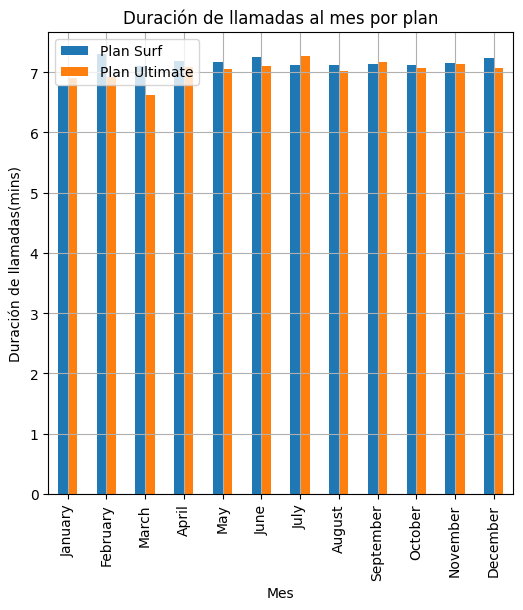

In [30]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

removed_columns_user = df_users.drop('first_name', axis=1).drop('last_name', axis=1).drop('age', axis=1).drop('city', axis=1).drop('reg_date', axis=1).drop('churn_date', axis=1)
merged_calls_plan = df_calls2.merge(removed_columns_user, on = ['user_id'], how = 'outer')

only_surf = merged_calls_plan[merged_calls_plan['plan'] == 'surf'].dropna(subset = ['duration_call']).sort_values(by= 'call_date', ascending = True)
only_ultimate = merged_calls_plan[merged_calls_plan['plan'] == 'ultimate'].dropna(subset = ['duration_call']).sort_values(by= 'call_date', ascending = True)


avg_per_month_surf = []
avg_per_month_ultimate = []

for month_surf in only_surf['month'].unique():
    temp_month_surf = only_surf[only_surf['month'] == month_surf]
    avg_duration = (temp_month_surf['duration_call'].mean())
    avg_per_month_surf.append([month_surf, avg_duration])
    
    
for month_ultimate in only_ultimate['month'].unique():
    temp_month_ultimate = only_ultimate[only_ultimate['month'] == month_ultimate]
    avg_duration_u = (temp_month_ultimate['duration_call'].mean())
    avg_per_month_ultimate.append([month_ultimate, avg_duration_u])
    
    
avg_duration_calls_surf = pd.DataFrame(data=avg_per_month_surf, columns=['month', 'avg_duration_surf'])
avg_duration_calls_ultimate = pd.DataFrame(data=avg_per_month_ultimate, columns=['month', 'avg_duration_ultimate'])

merged_plan_duration_calls = avg_duration_calls_surf.merge(avg_duration_calls_ultimate, on='month', how = 'outer')
print(merged_plan_duration_calls)


merged_plan_duration_calls.plot(x='month', y=['avg_duration_surf', 'avg_duration_ultimate'], kind='bar', figsize = [6, 6], title = 'Duración de llamadas al mes por plan', xlabel='Mes', ylabel='Duración de llamadas(mins)', grid=True)
plt.legend(['Plan Surf', 'Plan Ultimate'])
plt.show()



        month  total_minutes_surf  total_minutes_ultimate
0     January               406.0                   774.0
1    February              2673.0                  2822.0
2       March              7590.0                  3651.0
3       April             17577.0                  7074.0
4         May             30768.0                 11781.0
5        June             41836.0                 17435.0
6        July             54448.0                 25197.0
7      August             66438.0                 29922.0
8   September             80360.0                 37626.0
9     October            101846.0                 47778.0
10   November            119801.0                 56540.0
11   December            150680.0                 69324.0


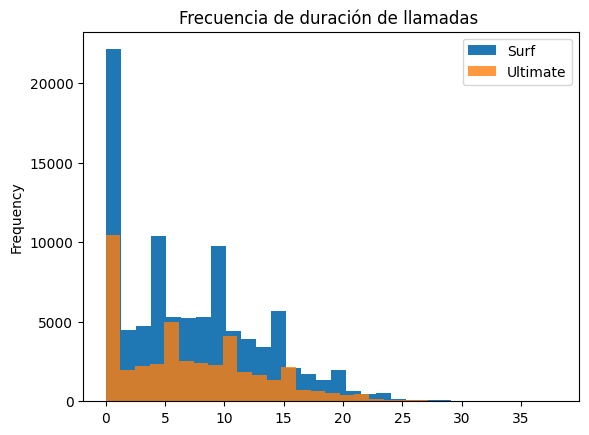

In [31]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

minutes_per_month_surf = []
minutes_per_month_ultimate = []
#print(only_surf)

for month_surf_minutes in only_surf['month'].unique():
    temp_minutes_surf = only_surf[only_surf['month'] == month_surf_minutes]
    minutes_needed = (temp_minutes_surf['duration_call'].sum())
    minutes_per_month_surf.append([month_surf_minutes, minutes_needed])
    
for month_ultimate_minutes in only_ultimate['month'].unique():
    temp_minutes_ultimate = only_ultimate[only_ultimate['month'] == month_ultimate_minutes]
    minutes_needed_u = (temp_minutes_ultimate['duration_call'].sum())
    minutes_per_month_ultimate.append([month_ultimate_minutes, minutes_needed_u])
    #print(minutes_per_month_ultimate)
    
total_minutes_calls_surf = pd.DataFrame(data=minutes_per_month_surf, columns=['month', 'total_minutes_surf'])
total_minutes_calls_ultimate = pd.DataFrame(data=minutes_per_month_ultimate, columns=['month', 'total_minutes_ultimate'])

merged_total_minutes_calls = total_minutes_calls_surf.merge(total_minutes_calls_ultimate, on='month', how = 'outer')
print(merged_total_minutes_calls)


only_surf['duration_call'].plot(kind='hist', bins=30)
only_ultimate['duration_call'].plot(kind='hist', bins=30, alpha=0.8, title= 'Frecuencia de duración de llamadas ')

plt.legend(['Surf', 'Ultimate']) 
plt.show()
#---------------------------------------------------------------------------------------------------
#NOTA: estoy dejando las llamdas con duración de 0 minutos ya que hay un registro de que sí se realizó una llamada
#---------------------------------------------------------------------------------------------------


#merged_total_minutes_calls.plot(x='month', y=['total_minutes_surf', 'total_minutes_ultimate'], kind='hist', alpha = 0.8, figsize = [6, 6], title = 'Total de minutos al mes por plan', xlabel='Mes', ylabel='Minutos totales', grid=True)
#plt.legend(['Plan Surf', 'Plan Ultimate'])
#plt.show()

In [32]:
# Calcula la media y la varianza de la duración mensual de llamadas.

mean_surf = merged_total_minutes_calls['total_minutes_surf'].mean()
mean_ultimate = merged_total_minutes_calls['total_minutes_ultimate'].mean()

variance_surf = np.var(merged_total_minutes_calls['total_minutes_surf'])
variance_ultimate = np.var(merged_total_minutes_calls['total_minutes_ultimate'])



print('Media plan surf:', mean_surf)
print('Media plan ultimate:', mean_ultimate)

print('Varianza plan surf:', variance_surf)
print('Varianza plan ultimate:', variance_ultimate)



Media plan surf: 56201.916666666664
Media plan ultimate: 25827.0
Varianza plan surf: 2202716344.5763893
Varianza plan ultimate: 478462892.0


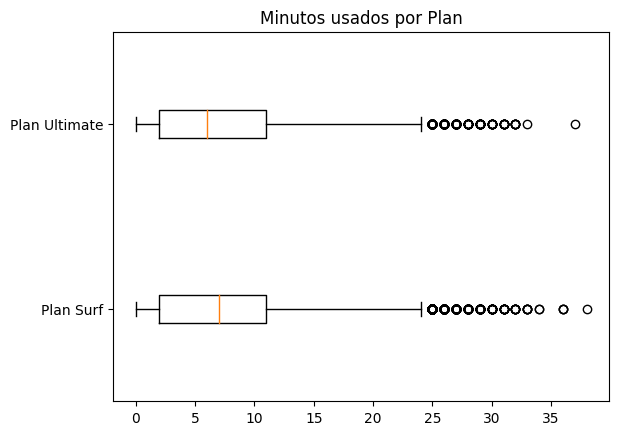

In [33]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.boxplot([only_surf['duration_call'] , only_ultimate['duration_call']], vert = False, labels = ['Plan Surf', 'Plan Ultimate'])
plt.title('Minutos usados por Plan')
plt.show()

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]

De acuerdo a las gráficas y a los datos arrojados por la varianza y la media, los usuarios del Plan Surf hacen más llamadas que los usuarios del Plan Ultimate. Esto puede deberse a que los clientes del Plan Surf se acaban los mensajes y GB de su plan antes que los del Plan Ultimate. De igual forma, puede deberse a que hay un número más grande de usuarios para el Plan Surf.

Los usuario del Plan Surf la mayoría duran 4 y 9 minutos por llamada, y los del Plan Ultimate la mayoría duran 6 y 11 minutos por llamada.

### Mensajes

        month  total_messages_surf  total_messages_ultimate
0     January                   21                       62
1    February                  108                      151
2       March                  351                      243
3       April                  870                      463
4         May                 1849                      931
5        June                 2454                     1379
6        July                 3271                     1937
7      August                 4662                     2732
8   September                 5968                     3259
9     October                 8020                     4181
10   November                 9165                     4903
11   December                12275                     6796


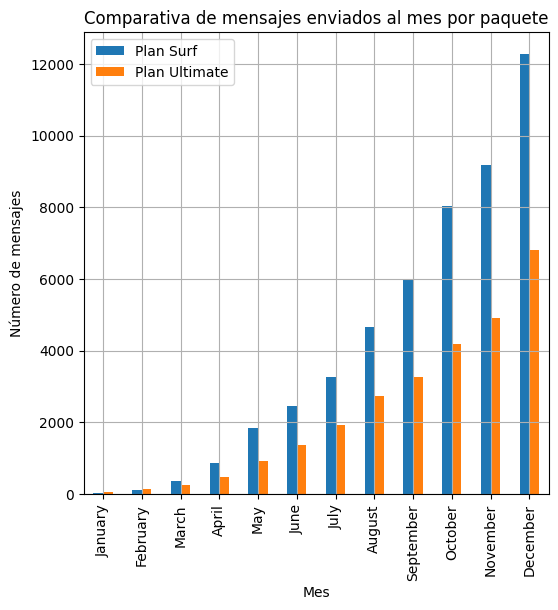

In [34]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

merged_messages_plan = df_messages2.merge(removed_columns_user, on = ['user_id'], how = 'outer').dropna(subset = ['message_date'])


only_surf_messages = merged_messages_plan[merged_messages_plan['plan'] == 'surf'].sort_values(by= 'message_date', ascending = True)
only_ultimate_messages = merged_messages_plan[merged_messages_plan['plan'] == 'ultimate'].sort_values(by= 'message_date', ascending = True)


messages_per_month_surf = []
messages_per_month_ultimate = []

for msg_surf in only_surf_messages['month'].unique():
    temp_msg_month_surf = only_surf_messages[only_surf_messages['month'] == msg_surf]
    messages_per_month_surf.append([msg_surf, len(temp_msg_month_surf)])
    
for msg_ultimate in only_ultimate_messages['month'].unique():
    temp_msg_month_ultimate = only_ultimate_messages[only_ultimate_messages['month'] == msg_ultimate]
    messages_per_month_ultimate.append([msg_ultimate, len(temp_msg_month_ultimate)])
    
total_messages_surf = pd.DataFrame(data=messages_per_month_surf, columns=['month', 'total_messages_surf'])
total_messages_ultimate = pd.DataFrame(data=messages_per_month_ultimate, columns=['month', 'total_messages_ultimate'])

merged_plan_messages = total_messages_surf.merge(total_messages_ultimate, on='month', how = 'outer')
print(merged_plan_messages)


merged_plan_messages.plot(x='month', y=['total_messages_surf', 'total_messages_ultimate'], kind='bar', figsize = [6, 6], title = 'Comparativa de mensajes enviados al mes por paquete', xlabel='Mes', ylabel='Número de mensajes', grid=True)
plt.legend(['Plan Surf', 'Plan Ultimate'])
plt.show()


In [35]:
# Calcula la media y la varianza de los mensajes mensuales.

mean_surf_messages = merged_plan_messages['total_messages_surf'].mean()
mean_ultimate_messages = merged_plan_messages['total_messages_ultimate'].mean()

variance_surf_messages = np.var(merged_plan_messages['total_messages_surf'])
variance_ultimate_messages = np.var(merged_plan_messages['total_messages_ultimate'])



print('Media plan surf:', mean_surf_messages)
print('Media plan ultimate:', mean_ultimate_messages)

print('Varianza plan surf:', variance_surf_messages)
print('Varianza plan ultimate:', variance_ultimate_messages)

Media plan surf: 4084.5
Media plan ultimate: 2253.0833333333335
Varianza plan surf: 14764949.916666666
Varianza plan ultimate: 4307875.909722221


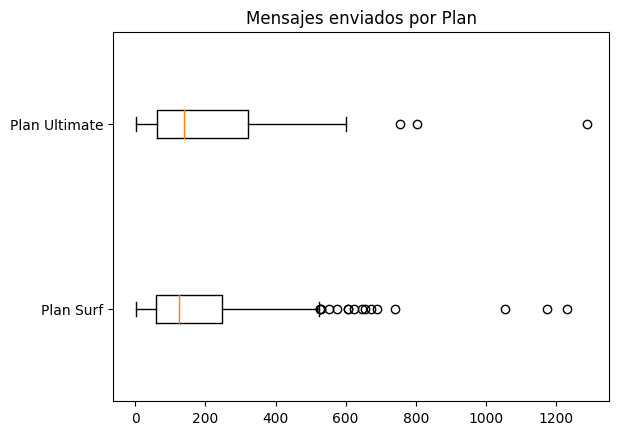

In [50]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes mensuales
surf_messages_grouped = only_surf_messages.groupby('user_id').count().reset_index()
ultimate_messages_grouped = only_ultimate_messages.groupby('user_id').count().reset_index()


#print(ultimate_messages_grouped.sort_values(by='id_messages'))
plt.boxplot([surf_messages_grouped['id_messages'] , ultimate_messages_grouped['id_messages']], vert = False, labels = ['Plan Surf', 'Plan Ultimate'])
plt.title('Mensajes enviados por Usuarios')
plt.show()

Los usuarios del Plan Surf usan con más fecuencia el envío de mensajes, siendo a finales de año cuando mayor envios de estos hay. En ambos casos, de acuerdo al diagrama de cajas, hay pocos usuarios que han mandado más de 1200 mensajes en 2018.

### Internet

        month  total_gb_surf  total_gb_ultimate
0     January           10.0               29.0
1    February          110.0              121.0
2       March          312.0              221.0
3       April          611.0              343.0
4         May         1087.0              489.0
5        June         1502.0              725.0
6        July         2042.0              973.0
7      August         2735.0             1267.0
8   September         3238.0             1463.0
9     October         4126.0             1878.0
10   November         4650.0             2174.0
11   December         5800.0             2778.0


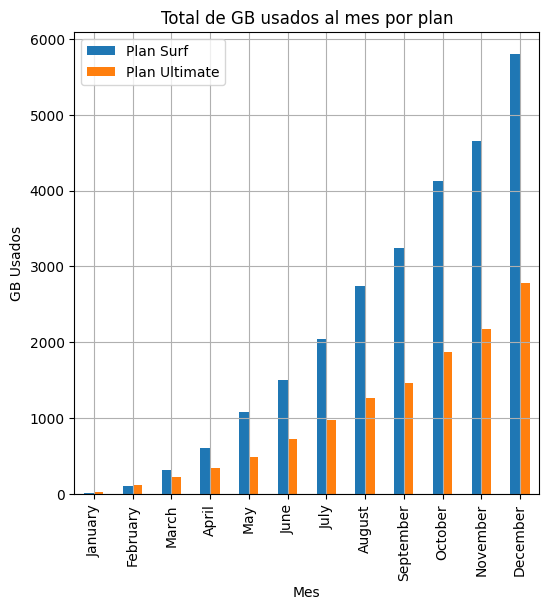

In [37]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

merged_internet_plan = df_internet2.merge(removed_columns_user, on = ['user_id'], how = 'outer').dropna(subset = ['session_date'])


internet_per_month_surf = []
internet_per_month_ultimate = []
acc_gb_per_month = 0
acc_gb_per_month2 = 0


only_surf_internet = merged_internet_plan[merged_internet_plan['plan'] == 'surf'].sort_values(by= 'session_date', ascending = True)
only_ultimate_internet = merged_internet_plan[merged_internet_plan['plan'] == 'ultimate'].sort_values(by= 'session_date', ascending = True)


for month_surf_internet in only_surf_internet['month'].unique():
    temp_internet_surf = only_surf_internet[only_surf_internet['month'] == month_surf_internet]    
    for user_internet in temp_internet_surf['user_id'].unique():
        temp_user_internet_surf = temp_internet_surf[temp_internet_surf['user_id'] == user_internet]
        subtotal_gb_per_user = np.ceil(temp_user_internet_surf['mb_used'].sum()/ 1024)
        acc_gb_per_month +=subtotal_gb_per_user
    internet_per_month_surf.append([month_surf_internet, acc_gb_per_month])
    acc_gb_per_month = 0

for month_surf_internet2 in only_ultimate_internet['month'].unique():
    temp_internet_ultimate = only_ultimate_internet[only_ultimate_internet['month'] == month_surf_internet2]
    for user_internet2 in temp_internet_ultimate['user_id'].unique():
        temp_user_internet_ultimate = temp_internet_ultimate[temp_internet_ultimate['user_id'] == user_internet2]
        subtotal_gb_per_user2 = np.ceil(temp_user_internet_ultimate['mb_used'].sum()/ 1024)
        acc_gb_per_month2 +=subtotal_gb_per_user2
    internet_per_month_ultimate.append([month_surf_internet2, acc_gb_per_month2])
    acc_gb_per_month2 = 0   

    
total_gb_surf = pd.DataFrame(data=internet_per_month_surf, columns=['month', 'total_gb_surf'])
total_gb_ultimate = pd.DataFrame(data=internet_per_month_ultimate, columns=['month', 'total_gb_ultimate'])

merged_total_gb_used = total_gb_surf.merge(total_gb_ultimate, on='month', how = 'outer')
print(merged_total_gb_used)


merged_total_gb_used.plot(x='month', y=['total_gb_surf', 'total_gb_ultimate'], kind='bar', figsize = [6, 6], title = 'Total de GB usados al mes por plan', xlabel='Mes', ylabel='GB Usados', grid=True)
plt.legend(['Plan Surf', 'Plan Ultimate'])
plt.show()


In [38]:
# Calcula la media y la varianza de los GB mensuales.

mean_surf_internet = merged_total_gb_used['total_gb_surf'].mean()
mean_ultimate_internet = merged_total_gb_used['total_gb_ultimate'].mean()

variance_surf_internet = np.var(merged_total_gb_used['total_gb_surf'])
variance_ultimate_internet = np.var(merged_total_gb_used['total_gb_ultimate'])



print('Media plan surf:', mean_surf_internet)
print('Media plan ultimate:', mean_ultimate_internet)

print('Varianza plan surf:', variance_surf_internet)
print('Varianza plan ultimate:', variance_ultimate_internet)

Media plan surf: 2185.25
Media plan ultimate: 1038.4166666666667
Varianza plan surf: 3419803.0208333335
Varianza plan ultimate: 722486.576388889


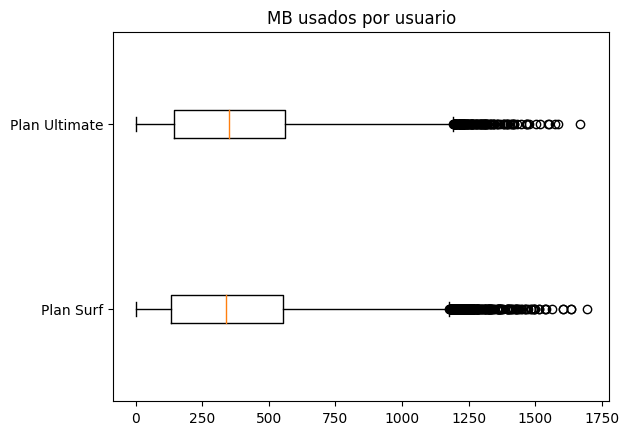

In [53]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes mensuales


plt.boxplot([only_surf_internet['mb_used'] , only_ultimate_internet['mb_used']], vert = False, labels = ['Plan Surf', 'Plan Ultimate'])
plt.title('MB usados por usuario')
plt.show()

Se puede observar que de igual forma como en las llamadas y en los mensajes, hay más usos de GB al mes en el Plan Surf que en el Plan Ultimate. También es posible observar que mes con mes hay un incremento en el uso de todos los servicios, lo que da a entender que cada vez más usuarios están usando los servicios con el pasar de los meses. En ambos planes los usuarios consumen alrededor de 150 a 580 mb.

## Ingreso

        month  total_revenue_surf  total_revenue_ultimate
0     January               40.00                   280.0
1    February              309.57                   490.0
2       March             1056.65                   896.0
3       April             2035.53                  1533.0
4         May             3667.37                  2051.0
5        June             4779.80                  3367.0
6        July             7583.56                  4242.0
7      August            10356.85                  5173.0
8   September            11304.67                  6195.0
9     October            15504.83                  7665.0
10   November            16415.21                  9107.0
11   December            22437.14                 11067.0


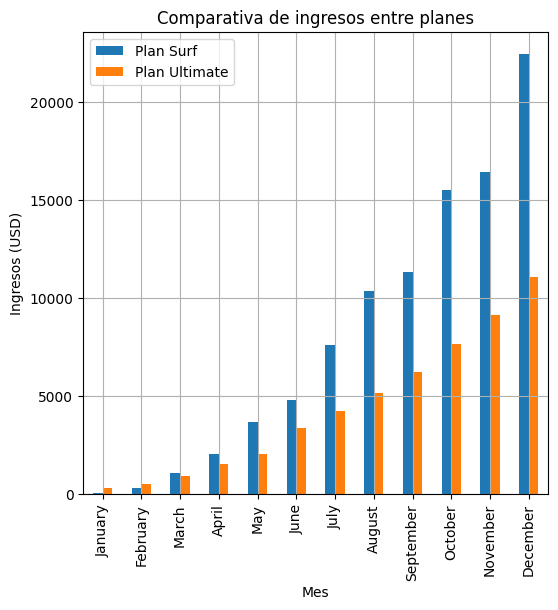

In [40]:
#print(merge_with_plans_clean)
stored_month_number =[]
columna_usuarios = merge_with_plans_clean['user_id']
columna_fecha = merge_with_plans_clean['month']

for current in merge_with_plans_clean['month']: # bucle para asignar el numero del mes para ordenarlo mejor
    if current == 'January':
        stored_month_number.append(1)
    elif current == 'February':
        stored_month_number.append(2)
    elif current == 'March':
        stored_month_number.append(3)
    elif current == 'April':
        stored_month_number.append(4)
    elif current == 'May':
        stored_month_number.append(5)
    elif current == 'June':
        stored_month_number.append(6)
    elif current == 'July':
        stored_month_number.append(7)
    elif current == 'August':
        stored_month_number.append(8)
    elif current == 'September':
        stored_month_number.append(9)
    elif current == 'October':
        stored_month_number.append(10)
    elif current == 'November':
        stored_month_number.append(11)
    elif current == 'December':
        stored_month_number.append(12)
    
        
        
new_revenue_df = pd.DataFrame(data=columna_usuarios, columns=['user_id'])
new_revenue_df['month'] = columna_fecha
new_revenue_df['month_sort'] = stored_month_number
new_revenue_df['total_revenue'] = merge_with_plans_clean['total_revenue']
new_revenue_df['plan'] = merge_with_plans_clean['plan']
new_revenue_df = new_revenue_df.sort_values(by='month_sort', ascending = True)
#print(new_revenue_df)
# Todos los bloques de código anterior fueron solamente para poder ordenar mejor posteriormente en la gráfica.


revenue_per_month_surf = []
revenue_per_month_ultimate = []
acc_revenue_per_month3 = 0
acc_gb_per_month4 = 0


only_surf_revenue = new_revenue_df[new_revenue_df['plan'] == 'surf'].sort_values(by= 'month_sort', ascending = True)
only_ultimate_revenue = new_revenue_df[new_revenue_df['plan'] == 'ultimate'].sort_values(by= 'month_sort', ascending = True)

for month_surf_revenue in only_surf_revenue['month'].unique():
    temp_revenue_surf = only_surf_revenue[only_surf_revenue['month'] == month_surf_revenue]    
    subtotal_revenue_per_month = round(temp_revenue_surf['total_revenue'].sum(), ndigits = 2)
    revenue_per_month_surf.append([month_surf_revenue,subtotal_revenue_per_month])
    
    
for month_ultimate_revenue in only_ultimate_revenue['month'].unique():
    temp_revenue_ultimate = only_ultimate_revenue[only_ultimate_revenue['month'] == month_ultimate_revenue]    
    subtotal_revenue_per_month2 = round(temp_revenue_ultimate['total_revenue'].sum(), ndigits = 2)
    revenue_per_month_ultimate.append([month_ultimate_revenue, subtotal_revenue_per_month2])

total_revenue_surf = pd.DataFrame(data=revenue_per_month_surf, columns=['month', 'total_revenue_surf'])
total_revenue_ultimate = pd.DataFrame(data=revenue_per_month_ultimate, columns=['month', 'total_revenue_ultimate'])

merged_total_revenue = total_revenue_surf.merge(total_revenue_ultimate, on='month', how = 'outer')
print(merged_total_revenue)


merged_total_revenue.plot(x='month', y=['total_revenue_surf', 'total_revenue_ultimate'], kind='bar', figsize = [6, 6], title = 'Comparativa de ingresos entre planes', xlabel='Mes', ylabel='Ingresos (USD)', grid=True)
plt.legend(['Plan Surf', 'Plan Ultimate'])
plt.show()




In [41]:
# Calcula la media y la varianza de los ingresos mensuales.

mean_surf_revenue = merged_total_revenue['total_revenue_surf'].mean()
mean_ultimate_revenue = merged_total_revenue['total_revenue_ultimate'].mean()

variance_surf_revenue = np.var(merged_total_revenue['total_revenue_surf'])
variance_ultimate_revenue = np.var(merged_total_revenue['total_revenue_ultimate'])



print('Media plan surf:', mean_surf_revenue)
print('Media plan ultimate:', mean_ultimate_revenue)

print('Varianza plan surf:', variance_surf_revenue)
print('Varianza plan ultimate:', variance_ultimate_revenue)

Media plan surf: 7957.598333333334
Media plan ultimate: 4338.833333333333
Varianza plan surf: 48968947.76556388
Varianza plan ultimate: 11700806.63888889


      user_id     month  month_sort  total_revenue  plan
167      1042   January           1          20.00  surf
1677     1362   January           1          20.00  surf
1686     1362  February           2          29.57  surf
653      1138  February           2          30.00  surf
158      1042  February           2          20.00  surf
...       ...       ...         ...            ...   ...
755      1157  December          12          20.24  surf
749      1156  December          12          50.00  surf
843      1175  December          12          43.27  surf
809      1168  December          12          20.00  surf
2292     1499  December          12          90.00  surf

[1573 rows x 5 columns]


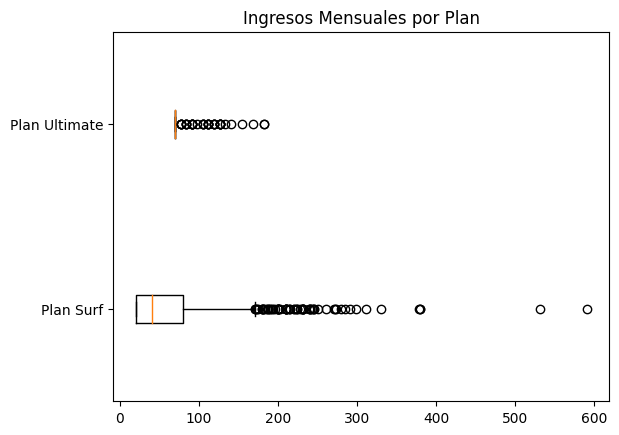

In [55]:
# Traza un diagrama de caja para visualizar la distribución de los ingresos mensuales
plt.boxplot([only_surf_revenue['total_revenue'] , only_ultimate_revenue['total_revenue']], vert = False, labels = ['Plan Surf', 'Plan Ultimate'])
plt.title('Ingresos Mensuales por Plan')
plt.show()

Con los datos obtenidos, se puede inferir que el plan Surf genera más ingresos que el plan Ultimate, en gran parte puede deberse al número de clientes que tienen dicho plan y a que las tarifas por servicios excedente cuestan un poco más que el plan Ultimate. A pesar de que el plan Ultimate es más caro, no genera los mismos ingresos que el Surf.

## Prueba las hipótesis estadísticas

In [43]:
# Prueba las hipótesis. Se usará el ejemplo de hipótesis sobre la igualdad de la media de dos poblaciones.
#La Hipótesis nula es que los ingresos promedio de los planes Surf y Ultimate son iguales.

#Hago dos conjuntos de datos, uno con el plan Surf y otro con plan Ultimate. Solo extraigo la columna de los ingresos.
sample_surf = merge_with_plans_clean[merge_with_plans_clean['plan'] == 'surf']['total_revenue']
sample_ultimate = merge_with_plans_clean[merge_with_plans_clean['plan'] == 'ultimate']['total_revenue']

alpha = 0.05

print('Varianza de ingresos de Plan Surf', np.var(sample_surf))
print('Varianza de ingresos de Plan Ultimate', np.var(sample_ultimate))

results = st.ttest_ind(sample_surf, sample_ultimate, equal_var = False)# Ponemos equal_var en False ya que las varianzas de ambos conjuntos no  son iguales o similares

print('valor p: ', results.pvalue)



if results.pvalue < alpha: # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula. Los ingresos de ambos planes NO son iguales.")
else:
    print("No podemos rechazar la hipótesis nula. Los ingresos de ambos planes SÍ son iguales")
    
    


Varianza de ingresos de Plan Surf 3065.8848438690247
Varianza de ingresos de Plan Ultimate 129.66814043209877
valor p:  3.1703905481135734e-15
Rechazamos la hipótesis nula. Los ingresos de ambos planes NO son iguales.


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [44]:
# Prueba las hipótesis. Se usará el ejemplo de hipótesis sobre la igualdad de la media de dos poblaciones.
#La Hipótesis nula es que los ingresos promedio de NY_NJ es igual que todas las otras regiones.
#La Hipótesis alternativa es que NY-NJ tiene ingresos diferentes a las otras regiones.


#Elimino columnas para dejar solamente la columna de city para fusionarla con el dataframe donde se encuentran los ingresos
#Tomo como referencia el número de usuario para hacer la fusión
cleaned_city_users = df_users.drop('first_name', axis=1).drop('last_name', axis=1).drop('age', axis=1).drop('reg_date', axis=1).drop('plan', axis=1).drop('churn_date', axis=1)
merged_revenue_per_city = merge_with_plans_clean.merge(cleaned_city_users, on='user_id', how = 'outer' ).dropna(subset = ['total_revenue'])


#Hago dos conjuntos de datos, uno con la ciudad de NY_NJ y otro con las demás ciudades. Solo extraigo la columna de los ingresos.
only_NY_NJ_rev = merged_revenue_per_city[merged_revenue_per_city['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_revenue']
besides_NY_NJ_rev = merged_revenue_per_city[merged_revenue_per_city['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_revenue']


alpha = 0.05

print('Varianza de ingresos de NY_NJ', np.var(only_NY_NJ_rev))
print('Varianza de ingresos de otras ciudades', np.var(besides_NY_NJ_rev))

results = st.ttest_ind(only_NY_NJ_rev, besides_NY_NJ_rev, equal_var = False)# Ponemos equal_var en False ya que las varianzas de ambos conjuntos no  son iguales o similares

print('valor p: ', results.pvalue)


if results.pvalue < alpha: # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula. Los ingresos NY-NJ NO son iguales a otras regiones")
else:
    print("No podemos rechazar la hipótesis nula. Los ingresos NY-NJ SÍ son iguales a otras regiones ")


Varianza de ingresos de NY_NJ 1890.5177172681153
Varianza de ingresos de otras ciudades 2223.8866958162175
valor p:  0.0335256158853001
Rechazamos la hipótesis nula. Los ingresos NY-NJ NO son iguales a otras regiones


## Conclusión general

De acuerdo al análisis estadístico de todas las tablas, el plan Surf es el más elegido por los clientes, y el que más ingresos genera a la empresa. En todos los servicios disponibles por la empresa, genera más ingresos y más uso de dichos servicios los del Plan Surf.

También por medio de la última hipótesis a pesar de que se rechazó la la hipótesis de que la ciudad de NY_NJ genera lo mismo que el conjunto de las otras ciudades, el p-value fue muy cercano a alpha como para no tomar en cuenta que esta ciudad es de las que mayores ingresos genera a la empresa.